![uelogo2.png](attachment:uelogo2.png)
# <font color=#444444> Proyecto Parte I - Ciclo de Vida de los Modelos </font>
### <font color=#999999> Postgrado Onlie IA y Data Science 2020-2021 </font>  
**PROFESOR**: 
**David Kremer García**

Este notebook sirve de guía para el desarrollo del proyecto del módulo de Ciclo de Vida de los Modelos. 

# MNIST 
El set de datos de MNIST (Modified National Institute of Standards and Technology) es muy conocido en problemas de tratamiento y clasificación de imágenes con Machine Learning y Deep Learning y sirve como problema de prueba con el que se desarrollan y miden la mayoría de los algoritmos de clasificación de imágenes.

Consite en un set de imágenes con dígitos escritos a mano. Cada imagen, en blanco y negro y de 28x28 píxeles, contiene un dígito del 0 al 9, y está anotada (está identificado el dígito que contiene). 

![image.png](attachment:image.png)

El problema consiste en identificar, dada una imagen, a cual de los dígitos corresponde (es un problema de clasificación). El set de datos contiene 70.000 imágenes de dígitos escritos a mano, separadas en 60.000 de training y 10.000 de testing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
import torch
from skimage.feature import hog

In [2]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

# 1. Carga, visualización/exploración y reescalado de las imágenes (2 puntos)

Las imágenes están almacenadas en formato pickle. Antes de desarrollar el modelo, al igual que hemos hecho en ejercicios anteriores, hay que cargar los datos y conviene hacer una exploración y visualización de las imágenes.

Este apartado consiste en:
 - Cargar las imágenes desde el pickle y comprobar el número de filas y resolución del dataset
 - Visualizar una serie de imágenes
 - Reescalar las imágenes para que los valores de los datos estén entre -0.5 y 0.5

In [3]:
!python3 -m pip install pykitml

In [4]:
import pickle
base_path = '/content/drive/MyDrive/Colab Notebooks/master/Unidad 4 - proyecto/'
file_path = base_path + 'data/'
with open(file_path+'MNIST_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)
with open(file_path+'MNIST_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)

In [5]:
print('Número de filas: ',X_train.shape[0])
print('Resolución del dataset: ', X_train.shape[1], 'x', X_train.shape[2])

Número de filas:  60000
Resolución del dataset:  28 x 28


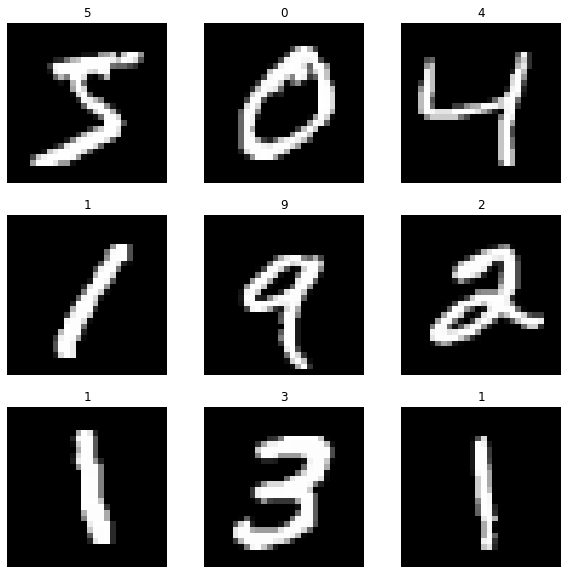

In [6]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i].reshape((28, 28)), cmap=cm.Greys_r)
  plt.title(y_train[i])
  plt.axis("off")

In [7]:
print(np.min(X_train[0]), np.max(X_train[0]))
X_train_n = ((X_train / 255.0)*2.0 - 1.0) / 2
X_test_n = ((X_test / 255.0)*2.0 - 1.0) / 2
print(np.min(X_train_n[0]), np.max(X_train_n[0]))


0 255
-0.5 0.5


# 2. Entrenamiento de modelos de ML tradicionales con HOG features (2 puntos)

Para conseguir modelos mas robustos, podemos hacer uso de HOG features para procesar las imágenes de forma que obtengamos unas variables de entrada mas genéricas que los valores específicos de los píxeles.

Esta parte consiste en, al igual que hicimos en ejercicios anteriores:
 - Extraer las HOG features de las imágenes para obtener un dataset transformado con el que entrenar
 - Elegir 3 algoritmos de ML clásico (de scikit-learn) y entrenar modelos de clasificación con el dataset transformado 

In [8]:
X_train_hog = np.concatenate([np.concatenate([hog(xi, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_train_n],
                                              axis=0) for ppc in [14,7,4]], axis=1)
X_test_hog = np.concatenate([np.concatenate([hog(xi, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test_n],
                                              axis=0) for ppc in [14,7,4]], axis=1)

In [9]:
print(X_train_hog.shape)
print(X_test_hog.shape)

(60000, 552)
(10000, 552)


In [10]:
from sklearn.ensemble import ExtraTreesClassifier
ext = ExtraTreesClassifier(n_estimators=100, random_state=123)
ext.fit(X=X_train_hog, y=y_train) 

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [11]:
print(ext.score(X=X_train_hog, y=y_train))
print(ext.score(X=X_test_hog, y=y_test))

1.0
0.9783


In [12]:
from sklearn import svm
svm1 = svm.LinearSVC()
svm1.fit(X=X_train_hog, y=y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [13]:
print(svm1.score(X=X_train_hog, y=y_train))
print(svm1.score(X=X_test_hog, y=y_test))

0.98545
0.9772


In [14]:
from sklearn.neural_network import MLPClassifier
mlp1 = MLPClassifier(alpha=1, max_iter=1000)
mlp1.fit(X=X_train_hog, y=y_train) 

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [15]:
print(mlp1.score(X=X_train_hog, y=y_train))
print(mlp1.score(X=X_test_hog, y=y_test))

0.9667333333333333
0.9695


# 3.	Grid search de hiperparámetros de los modelos y HOG features (1 punto)

Para refinar los modelos entrenados en el apartado anterior, en este apartado el objetivo es:
- Desarrollar una pipeline de scikit-learn con las transformaciones realizadas (incluyendo HOG features) y los modelos desarrollados
- Hacer un grid search sobre esta pipeline para hacer una selección de los hiperparámetros los modelos y de los hiperparámetros de la transformación HOG

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class ReshapeDot5(BaseEstimator, TransformerMixin):
    """
    Reshape array between 0.5 and -0.5
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        return ((X.reshape(X.shape[0],-1) / 255.0)*2.0 - 1.0) / 2
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, 
                 orientations=8, 
                 pixels_per_cell=(8, 8),
                 cells_per_block=(1, 1), 
                 block_norm='L1'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        return np.concatenate([hog(xi, orientations=self.orientations, 
                              pixels_per_cell=self.pixels_per_cell,
                              cells_per_block=self.cells_per_block, 
                              visualize=False,
                              block_norm=self.block_norm)[np.newaxis, :] for xi in X])

In [17]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('hogify', HogTransformer()),
    ('classify', svm.LinearSVC())
])

clf = HOG_pipeline.fit(X_train_n, y_train)

In [18]:
print('Percentage correct: ', 100*np.sum(clf.predict(X_test_n) == y_test)/len(y_test))

Percentage correct:  91.21


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__pixels_per_cell': [(8, 8), (10, 10)],
        'hogify__cells_per_block': [(1, 1), (2, 2)],
        'hogify__block_norm': ['L2-Hys', 'L1']
    },
    {
        'hogify__orientations': [8],
        'hogify__pixels_per_cell': [(8, 8)],
         'hogify__cells_per_block': [(1, 1)],
         'classify': [
            ExtraTreesClassifier(n_estimators=100, random_state=123),
            svm.LinearSVC(),
            MLPClassifier(alpha=1, max_iter=1000)
         ]
    }
]

In [20]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
#grid_res = grid_search.fit(X_train_n, y_train)

In [21]:
#grid_res.best_estimator_

In [22]:
# the highscore during the search
#grid_res.best_score_

In [23]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(grid_res.best_params_)

# 4. Diseño de red neuronal “fully connected”, no convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, los modelos de Deep Learning son capaces de "capturar" features a partir de los datos. 

El objetivo de esta sección es:
- Construir una red neuronal no convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [24]:
history = {}

In [25]:
import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential

def dense_model(units, dropout):
  model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(units, activation='relu'),
    Dropout(dropout),
    Dense(units, activation='relu'),
    Dropout(dropout),
    Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [26]:
hyperparameters = {
    'epochs': [100],
    'batch_size': [64],
    'units': [32, 64, 128],
    'dropout': [0.1, 0.2, 0.4]
}

In [27]:
model = dense_model(64, 0.4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
____________________________________________________

In [28]:
print(X_test_n[0].shape)
print(np.expand_dims(X_test_n[0],0).shape)
pass_forward = model.predict(np.expand_dims(X_test[0],0))
print(pass_forward)

(28, 28)
(1, 28, 28)
[[0.0000000e+00 9.6399236e-11 1.0000000e+00 0.0000000e+00 0.0000000e+00
  2.3791729e-22 1.9480972e-11 0.0000000e+00 7.6133880e-13 0.0000000e+00]]


In [29]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=dense_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=6, verbose=4)
#grid_result = grid.fit(X_train_n.reshape(-1, 28*28), y_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#Best: 0.967000 using {'batch_size': 64, 'dropout': 0.1, 'epochs': 100, 'units': 128}

In [30]:
#print(np.argmax(y_test, axis=1), grid.predict(X_test_n.reshape(-1, 28*28)))
print()
#print(classication_report(y_true, y_pred))

# 5. Entrenamiento red neuronal “fully connected”. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [31]:
model = dense_model(128, 0.1)
history["fully"] = model.fit(X_train_n, y_train,
          batch_size=64,
          epochs=1,
          verbose=1,
          validation_data=(X_test_n, y_test))

938/938 [==============================] - 3s 3ms/step - loss: 0.6490 - accuracy: 0.7963 - val_loss: 0.1822 - val_accuracy: 0.9435


# 6. Diseño de red neuronal convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, las redes convolucionales presentan mejores resultados para la clasificación de imágenes, ya que capturan mejor la estructura y correlación entre píxeles cercanos. 

El objetivo de esta sección es:
- Construir una red neuronal convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [32]:
X_train_n_expand = np.expand_dims(X_train_n, -1)
X_test_n_expand = np.expand_dims(X_test_n, -1)

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input

def convolutional_model(units, convShape, maxPoolShape):
  model = Sequential([
    Conv2D(units, convShape, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(maxPoolShape),
    Conv2D(units*2, convShape, activation='relu'),
    MaxPooling2D(maxPoolShape),
    Conv2D(units*2, convShape, activation='relu'),
    Flatten(),
    Dense(units*2, activation='relu'),
    Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [34]:
model_conv = convolutional_model(32,(3, 3), (2, 2))
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [35]:
pass_forward_conv = model_conv.evaluate(X_test_n_expand,y_test)
print(pass_forward_conv)

313/313 [==============================] - 11s 2ms/step - loss: 2.3140 - accuracy: 0.0767
[2.3141496181488037, 0.07500000298023224]


In [36]:
def deep_convolutional_model(units, convShape):
  model = Sequential([
    Conv2D(units, convShape, activation='relu', padding='same', input_shape=(28, 28, 1)),
    Conv2D(units, convShape, activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),
    Conv2D(units*2, convShape, activation='relu', padding='same'),
    Conv2D(units*2, convShape, activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),
    Conv2D(units*4, convShape, activation='relu', padding='same'),
    Conv2D(units*4, convShape, activation='relu', padding='same'),
    Conv2D(units*4, convShape, activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),
    Flatten(),
    Dense(units*8, activation='relu'),
    Dense(units*8, activation='relu'),
    Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [37]:
deep_model_conv = deep_convolutional_model(64,(3, 3))
deep_model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 256)        

# 7. Entrenamiento red neuronal convolucional. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

In [38]:
import tensorflow as tf

In [39]:
epochs=1

In [40]:
import os
#os.mkdir('/tmp/mnist')
checkpoint_filepath = '/tmp/mnist/cnn/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [41]:
history["cnn"] = model_conv.fit(X_train_n_expand, y_train,
          batch_size=64,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_n_expand, y_test)
         # ,callbacks=[model_checkpoint_callback])
)

938/938 [==============================] - 4s 4ms/step - loss: 0.1880 - accuracy: 0.9421 - val_loss: 0.0435 - val_accuracy: 0.9856


In [42]:
checkpoint_filepath = '/tmp/mnist/deepcnn/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [43]:
history["deepcnn"] = deep_model_conv.fit(X_train_n_expand, y_train,
          batch_size=64,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_n_expand, y_test)
         # ,callbacks=[model_checkpoint_callback])
)

938/938 [==============================] - 15s 15ms/step - loss: 0.6042 - accuracy: 0.7797 - val_loss: 0.0669 - val_accuracy: 0.9840


# 8. Comparativa de métricas y matrices de confusión entre todos los modelos entrenados de ML y DL. (1 punto)

El objetivo de esta sección es comparar los resultados obtenidos entre los distintos modelos (ML, NN, CNN). 

En particular:
- Mostrar la matriz de confusión para cada modelo.
- Elegir y dibujar algunas métricas adicionales. 
- Describir las conclusiones.

In [44]:
model_conv = tf.keras.models.load_model(base_path + 'mnist/cnn/model')
deep_model_conv = tf.keras.models.load_model(base_path + 'mnist/deepcnn/model')

In [45]:
from sklearn.metrics import classification_report

def show_classification_report(test, predict, title='model name'):
  print('------------------------------------------------------------')
  print(title)
  print('------------------------------------------------------------')
  print(classification_report(test, predict, labels=list(range(10))))

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
#model.predict(X_test_n)
def show_confusion_matrix(test, predict, title='model name'):
  cm = confusion_matrix(test, predict, labels=list(range(10)))
  df_cm = pd.DataFrame(cm, index = list(range(10)), columns = list(range(10)))
  plt.figure(figsize = (10,7))
  plt.title(title)
  sn.heatmap(df_cm, annot=True, vmin=0, vmax=20)

In [47]:
show_classification_report(y_test, np.argmax(model.predict(X_test_n_expand), axis=1).tolist(), "Red neuronal 'fully connected'")
show_classification_report(y_test, np.argmax(model_conv.predict(X_test_n_expand), axis=1).tolist(), "Red neuronal 'Convolutional'")
show_classification_report(y_test, np.argmax(deep_model_conv.predict(X_test_n_expand), axis=1).tolist(), "Red neuronal 'Deeper Convolutional'")
show_classification_report(y_test, ext.predict(X_test_hog), "ExtraTreesClassifier")
show_classification_report(y_test, mlp1.predict(X_test_hog), "MLPClassifier")
show_classification_report(y_test, svm1.predict(X_test_hog), "LinearSVC")

------------------------------------------------------------
Red neuronal 'fully connected'
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.97      0.98      1135
           2       0.93      0.96      0.94      1032
           3       0.91      0.96      0.93      1010
           4       0.89      0.97      0.93       982
           5       0.95      0.92      0.93       892
           6       0.97      0.95      0.96       958
           7       0.97      0.90      0.93      1028
           8       0.95      0.92      0.93       974
           9       0.94      0.90      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

------------------------------------------------------------
Red neuronal 'Convolutional

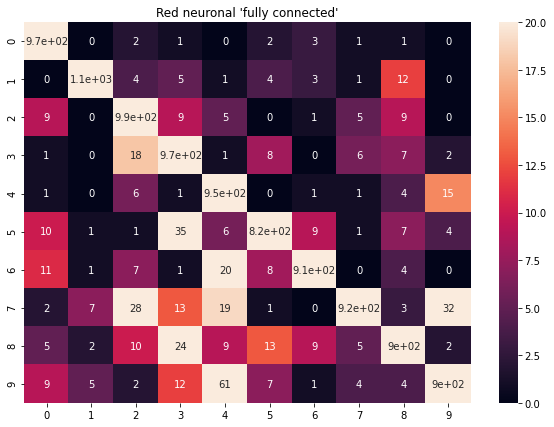

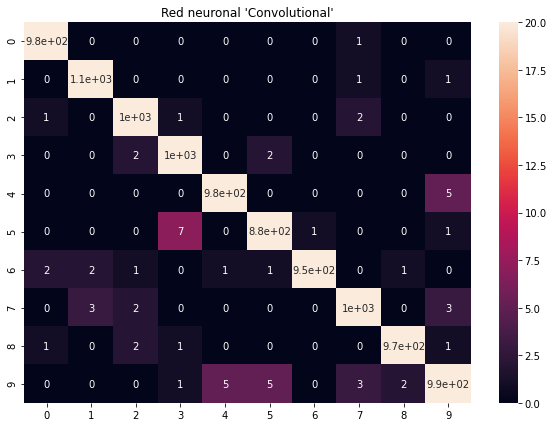

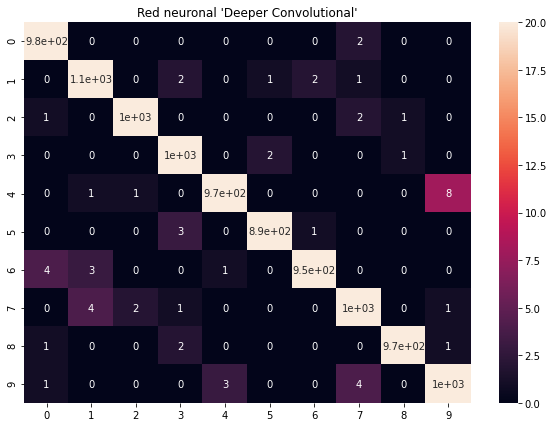

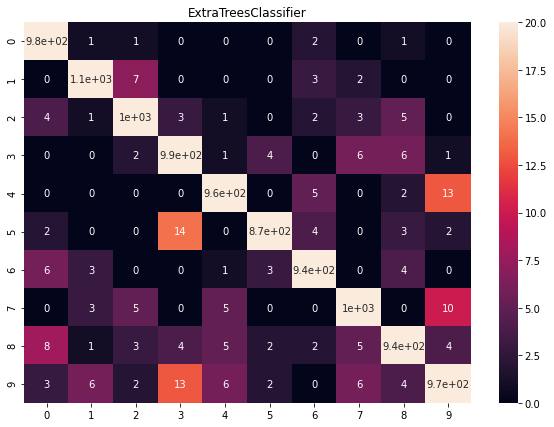

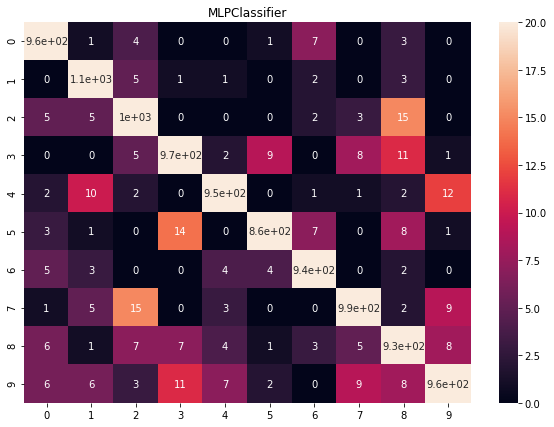

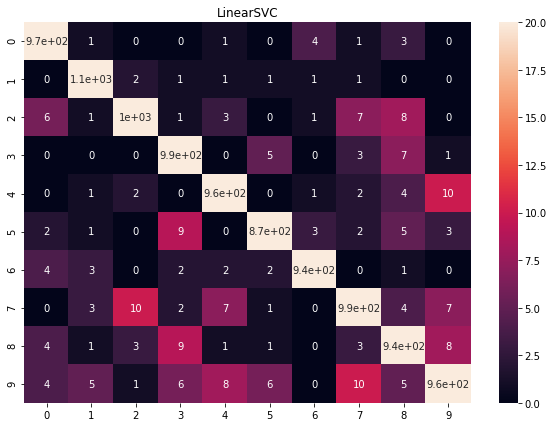

In [48]:
show_confusion_matrix(y_test, np.argmax(model.predict(X_test_n_expand), axis=1).tolist(), "Red neuronal 'fully connected'")
show_confusion_matrix(y_test, np.argmax(model_conv.predict(X_test_n_expand), axis=1).tolist(), "Red neuronal 'Convolutional'")
show_confusion_matrix(y_test, np.argmax(deep_model_conv.predict(X_test_n_expand), axis=1).tolist(), "Red neuronal 'Deeper Convolutional'")
show_confusion_matrix(y_test, ext.predict(X_test_hog), "ExtraTreesClassifier")
show_confusion_matrix(y_test, mlp1.predict(X_test_hog), "MLPClassifier")
show_confusion_matrix(y_test, svm1.predict(X_test_hog), "LinearSVC")

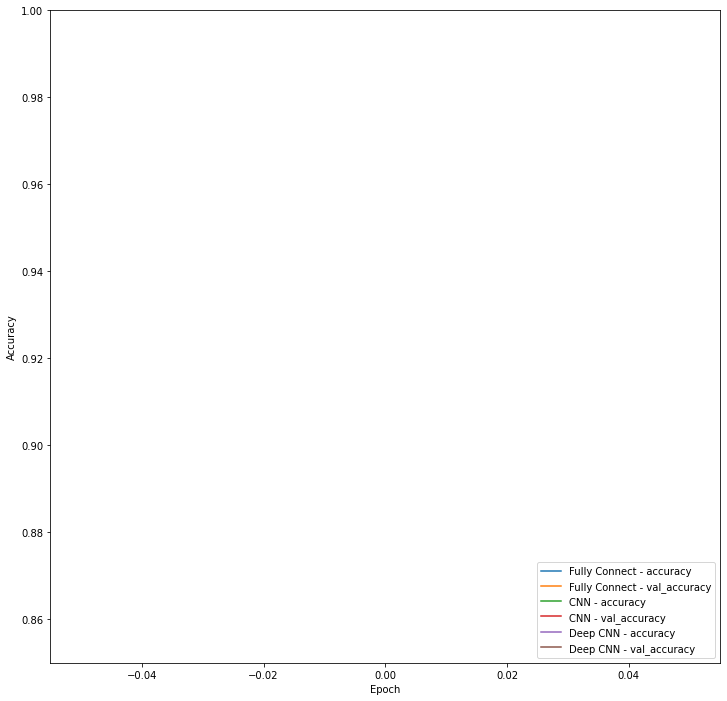

In [49]:
plt.plot(history["fully"].history['accuracy'], label='Fully Connect - accuracy')
plt.plot(history["fully"].history['val_accuracy'], label = 'Fully Connect - val_accuracy')
plt.plot(history["cnn"].history['accuracy'], label='CNN - accuracy')
plt.plot(history["cnn"].history['val_accuracy'], label = 'CNN - val_accuracy')
plt.plot(history["deepcnn"].history['accuracy'], label='Deep CNN - accuracy')
plt.plot(history["deepcnn"].history['val_accuracy'], label = 'Deep CNN - val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

# 9. Comparativa de la robustez de los distintos modelos entrenados frente a la translación horizontal de los dígitos. (0,5 puntos)

El objetivo de esta sección es:
- Probar el rendimiento de los modelos entrenados sobre distintas transformaciones del set de testing (por ejemplo, sobre translaciones horizontales como se mostró en las sesiones de este módulo).
- Dibujar las gráficas correspondientes de acierto frente a la magnitud de la transformación (por ej. cantidad de píxeles desplazados).
- Describir las conclusiones.

In [50]:
X_test_n.shape

(10000, 28, 28)

In [108]:
num_fotos_test = 50

In [51]:
tr_W = np.array(list(range(-50,50)))
X_test_Ws = [np.roll(X_test_n[:num_fotos_test], i, axis=2) for i in tr_W]

In [111]:
X_test_Ws_flat = []
for i in range(num_fotos_test):
    for item in [np.transpose(xi[i,:,:],(0,1)) for xi in X_test_Ws]:
      X_test_Ws_flat.append(item)

In [112]:
X_test_Ws_hog = np.concatenate([np.concatenate([hog(xi, orientations=8, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test_Ws_flat],
                                              axis=0) for ppc in [14,7,4]], axis=1)

In [113]:
y_test_Ws = []
for i in y_test[:50]:
  for j in range(100):
    y_test_Ws.append(i)

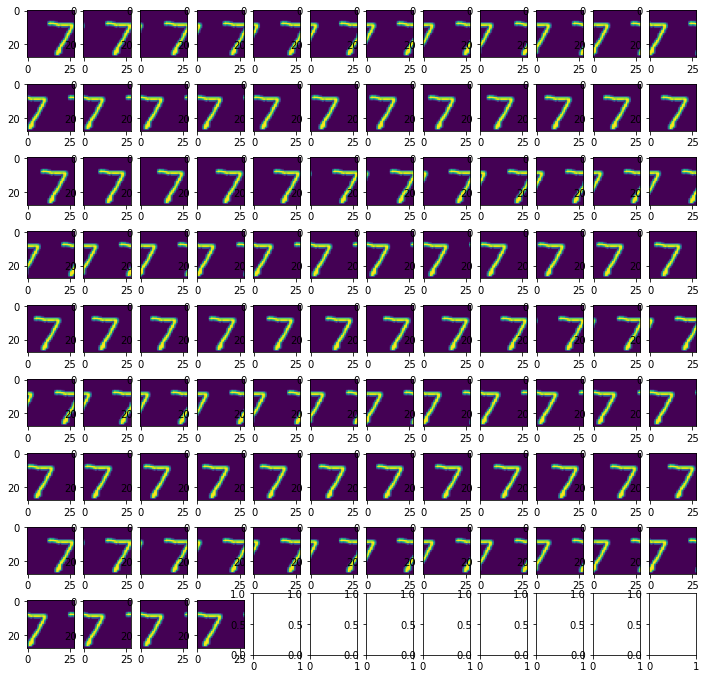

In [114]:
im = io.imshow_collection([np.transpose(xi[0,:,:],(0,1)) for xi in X_test_Ws])

In [115]:
X_test_Ws_flat_expand = np.expand_dims(X_test_Ws_flat, -1)

In [119]:
print(y_test_Ws[:100])
print(np.argmax(model_conv.predict(X_test_Ws_flat_expand), axis=1).tolist()[:100])

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[5, 5, 5, 5, 5, 5, 1, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 1, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 1, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 1, 6, 7, 7, 7, 7, 7, 7, 7, 7]


In [117]:
show_classification_report(y_test_Ws, np.argmax(model.predict(X_test_Ws_flat_expand), axis=1).tolist(), "Red neuronal 'fully connected'")
show_classification_report(y_test_Ws, np.argmax(model_conv.predict(X_test_Ws_flat_expand), axis=1).tolist(), "Red neuronal 'Convolutional'")
show_classification_report(y_test_Ws, np.argmax(deep_model_conv.predict(X_test_Ws_flat_expand), axis=1).tolist(), "Red neuronal 'Deeper Convolutional'")
show_classification_report(y_test_Ws, ext.predict(X_test_Ws_hog), "ExtraTreesClassifier")
show_classification_report(y_test_Ws, mlp1.predict(X_test_Ws_hog), "MLPClassifier")
show_classification_report(y_test_Ws, svm1.predict(X_test_Ws_hog), "LinearSVC")

------------------------------------------------------------
Red neuronal 'fully connected'
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.21      0.24      0.22       500
           1       0.44      0.07      0.12       900
           2       0.40      0.58      0.47       500
           3       0.24      0.22      0.23       400
           4       0.49      0.26      0.34       900
           5       0.09      0.41      0.14       400
           6       0.40      0.19      0.26       300
           7       0.24      0.21      0.22       600
           8       0.00      0.00      0.00         0
           9       0.74      0.18      0.29       500

    accuracy                           0.24      5000
   macro avg       0.33      0.23      0.23      5000
weighted avg       0.38      0.24      0.25      5000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------
Red neuronal 'Convolutional'
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.22      0.33       500
           1       0.32      0.42      0.37       900
           2       0.42      0.51      0.46       500
           3       0.52      0.28      0.36       400
           4       0.46      0.54      0.50       900
           5       0.33      0.54      0.41       400
           6       0.30      0.26      0.28       300
           7       0.45      0.46      0.45       600
           8       0.00      0.00      0.00         0
           9       0.91      0.27      0.42       500

    accuracy                           0.41      5000
   macro avg       0.44      0.35      0.36      5000
weighted avg       0.48      0.41      0.41      5000

------------------------------------------------------------
Red neuronal 'Deeper Convolut

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 10. Desarrollo de una función de preprocesado / reescalado para input al modelo, y exportación del modelo escogido. (0,5 puntos)


El objetiivo de esta sección es el de preparar el modelo para su despliegue en la Parte II de la práctica.

Para ello, habrá que:
- Seleccionar el mejor modelo entre los probados (típicamente, debería ser la CNN).
- Construir una función de preprocesado (o una pipeline de scikit-learn, o equivale) que transforme una imágen genérica en algo consumible por el modelo, replicando también las transformaciones hechas durante el entrenamiento.
- Exportar el modelo y la pipeline en un formato importable desde una aplicación python, como por ejemplo un fichero “.pt” (pytorch) con los pesos de la red neuronal, o una de la pipeline entera a un fichero “.pkl” (pickle).


In [120]:
from skimage.transform import resize

In [187]:
def preprocess(input_img):
    if len(input_img.shape) == 3:
      input_img = input_img[:,:,1]
    imgg = ((input_img / np.max(input_img))*2.0 - 1.0) / 2
    return resize(imgg, (28,28), anti_aliasing=True)

In [162]:
def predict_img(input_img):
    pre_img = preprocess(input_img)
    t_img = np.expand_dims([pre_img], -1)
    pred_n = np.argmax(deep_model_conv.predict(t_img), axis=1)
    pred_p = deep_model_conv.predict(t_img)
    return pred_n, pred_p

In [189]:
def show_prediction(img):
  item,_ = predict_img(img)
  plt.figure(figsize=(10, 10))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(preprocess(img), cmap=cm.Greys_r)
  plt.title(item)
  plt.axis("off")

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


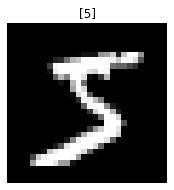

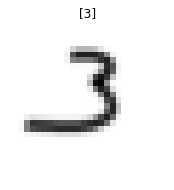

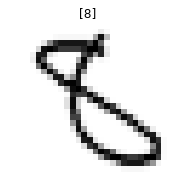

In [190]:
from skimage import io
show_prediction(X_train[0])
show_prediction(io.imread('/content/test.png'))
show_prediction(io.imread('/content/test2.png'))

